# CNNs for 54x54 image size

# Import all modules

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import PIL.Image as Image
import PIL.ImageChops as ImageChops
import PIL.ImageFilter as ImageFilter
import PIL.ImageEnhance as ImageEnhance
import os
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import OrderedDict
import pandas as pd
import matplotlib 

# load gray scale data from pickle file 54x54 images


In [2]:

pickle_file = 'SVHN_multin54.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_t = save['train_dataset']
  train_labels_t = save['train_labels']
  valid_dataset_t = save['valid_dataset']
  valid_labels_t = save['valid_labels']
  test_dataset_t = save['test_dataset']
  test_labels_t = save['test_labels']
  del save  
  print('Training set', train_dataset_t.shape, train_labels_t.shape)
  print('Validation set', valid_dataset_t.shape, valid_labels_t.shape)
  print('Test set', test_dataset_t.shape, test_labels_t.shape)

Training set (230070, 54, 54, 1) (230070, 6)
Validation set (5684, 54, 54, 1) (5684, 6)
Test set (13068, 54, 54, 1) (13068, 6)


# Define accuracy function
How many digits did we  right?

In [3]:
#how much house numbers are correct -> alle digits of a house number must be correct
def accuracy(predictions, labels,show_details=False,n=100):
 
  if show_details:
        for i in range(0,n):
            print(labels[i],'  ',predictions[i],'  ',np.all(labels[i] == predictions[i]))
  return (100.0 * np.sum(np.all(predictions == labels,axis=1)))/ predictions.shape[0]




#define character level accuracy measuere

def accuracyCharLevel(predictions, labels):

  return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

print("Success")

Success


## Function to display random images with labels

In [4]:
def display_images(images, labels, rand_indices=None):
    """
        Display random images from a set and return indices so we can match the results
    """
    display_size = 10
    display_per_row = 10
    num_rows = display_size/display_per_row
    if rand_indices is None:
        rand_indices = np.random.randint(0, images.shape[0], size=display_size)
    row_size = 20
    col_size = 20

    fig = plt.figure(figsize=(20, 20))
    for idx in range(len(rand_indices)):
        orig_idx = rand_indices[idx]
        display_row_idx = int(idx/display_per_row) + 1
        display_col_idx = idx%display_per_row +1
        a=fig.add_subplot(display_row_idx, display_per_row, display_col_idx, frameon=False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
        a.imshow(images[orig_idx,:,:,0], cmap="Greys_r")
        
        house_num = ''
        for k in np.arange(labels[orig_idx,0]):
            house_num += str(labels[orig_idx,k+1])
      
        a.set_title(house_num)
    return rand_indices

## Show some preprocessed images from training and test data sets with labels

array([ 3684, 11410, 10438,  3899,  7372,  7328,  6164,  8292,  9580,  5315])

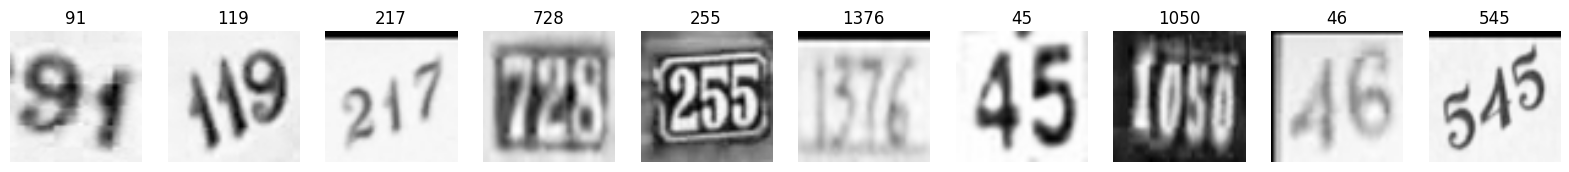

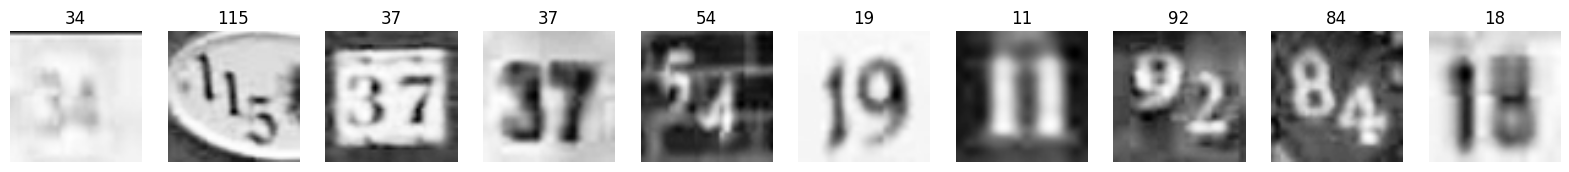

In [5]:
display_images(train_dataset_t, train_labels_t)
display_images(test_dataset_t, test_labels_t)

# Data augmentation
## Helper functions to convert images from numpy to PIL and back

In [6]:
def array2image(fa):
   
    return Image.frombytes("F", (fa.shape[1], fa.shape[0]), fa.tostring())
   

def image2Array(img):    
    ar=np.array(img)*1.0
    return ar

[[-0.32730103 -0.25639343 -0.65870667 ..., -0.07980347 -0.72079468
  -0.36160278]
 [-0.91430664 -0.61549377 -0.07170105 ..., -0.60670471 -0.83479309
  -0.06269836]
 [-0.91430664 -0.02839661 -0.66960144 ..., -0.01950073 -0.94869995
  -0.29060364]
 ..., 
 [-0.87109375 -0.57220459 -0.98510742 ..., -0.74679565 -0.7467041
  -0.33380127]
 [-0.87130737 -0.87139893 -0.686203   ..., -0.7467041  -0.7467041
  -0.92080688]
 [-0.17019653 -0.45840454 -0.38729858 ..., -0.03489685 -0.1598053
  -0.21969604]]


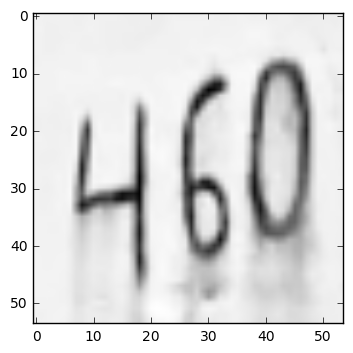

In [7]:
#some test
idx=0
npim=train_dataset_t[idx,:,:,0]

im=array2image(npim).convert("L")
plt.imshow(im,cmap="Greys_r")


npimg=image2Array(im)
print(npimg-npim)

## Augment one image

In [8]:
from time import time
def generateAugmentedData(npimg,label,images,labels,n=1):
  
    #first append original image
    images.append(npimg)
    labels.append(label)
    im=array2image(npimg).convert("L")
    # do n random rotations 
    for i in range(0,n):
        rot=np.random.uniform(-20,20)
        img=im.rotate(rot,Image.BILINEAR)
        images.append(image2Array(img))
        labels.append(label)
    #do n random movements    
    for i in range(0,n):
        dx=np.random.randint(-5,5)
        dy=np.random.randint(-5,5)
        img=ImageChops.offset(im,dx,dy)
        images.append(image2Array(img))
        labels.append(label)
    #do n random sharpness operations
    enhancer = ImageEnhance.Sharpness(im)
    for i in range(0,n):
        en=np.random.uniform(-2,3)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)
    
   #do n random brightness operations
    enhancer = ImageEnhance.Brightness(im)
    for i in range(0,n):
        en=np.random.uniform(0.01,2)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)
    #do n random contrast operations
    enhancer = ImageEnhance.Contrast(im)
    for i in range(0,n):
        en=np.random.uniform(0.01,3)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)

 
    return images,labels
    


230070
164.535
1.38282775879e-05
164.535
time used s 0.642488956451
6000
311.754554382


xrange(10)

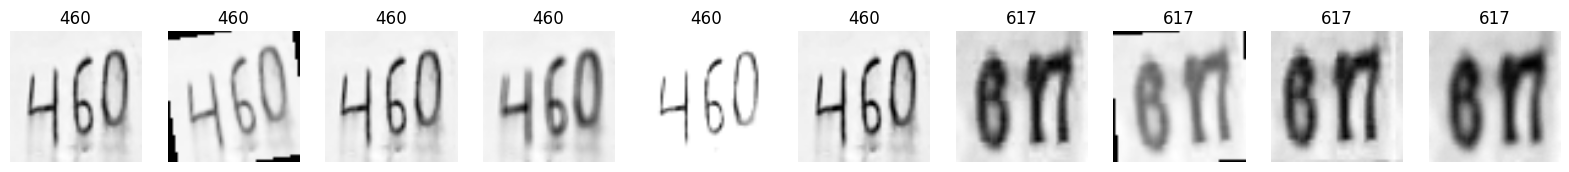

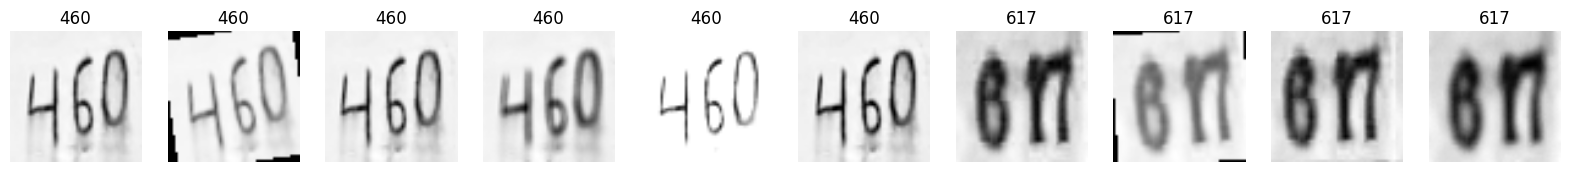

In [9]:
#some tests
idx=0
print (len(train_dataset_t))
npim=train_dataset_t[idx,:,:,0]
print(np.mean(npim))
mean=np.mean(npim)
imn=train_dataset_t[idx]-mean
print(np.sum(imn)/1024.0)
print(np.mean(train_dataset_t[idx]))
t0=time()
images=[]
labels=[]
for idx in range(0,1000):
    npim=train_dataset_t[idx,:,:,0]
    images,labels=generateAugmentedData(npim, train_labels_t[idx],images,labels) 

dataset = np.ndarray([len(images),54,54,1], dtype='float32')
for idx in range(0,len(images)):
    image=images[idx]
  #  print(image[:,:,np.newaxis].shape)
  #  im=image[:,:,np.newaxis]
  
    dataset[idx,:,:,:] = image[:,:,np.newaxis]
print ("time used s",time()-t0)    
print(len(dataset))
ind=range(0,10)
display_images(dataset, np.array(labels),ind)   

sum=0.0
for idx in range(0,len(images)):
    image= dataset[idx,:,:,:]
    sum+=np.sum(image)/1024.0
print (sum/len(images))    
mean=np.mean(dataset)
std=np.std(dataset)
display_images((dataset-mean)/std, np.array(labels),ind)   

In [10]:
def generateAugmentedDataSet(image_data,image_label,n=2):
    init=True
    labels=[]
    len_data=len(image_data)
   
    for idx in range(0,len_data):    
        if idx%20000==0:
            print(idx)
        npim=image_data[idx,:,:,0]
        images=[]
      
        images,labels=generateAugmentedData(npim, image_label[idx],images,labels,n) 
        lenIm=len(images)
       
        if init==True:
            print(lenIm)
            img_dataset = np.ndarray([lenIm*len_data,54,54,1], dtype='float32')
            init=False
        for i in range(0,lenIm):
            image=images[i]
            img_dataset[idx*lenIm+i,:,:,:] = image[:,:,np.newaxis]
    img_lables=np.array(labels)   
    del labels
    return img_dataset, img_lables 

0
16
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
0
6
0
6
230070 3681120
5684 34104
13068 78408


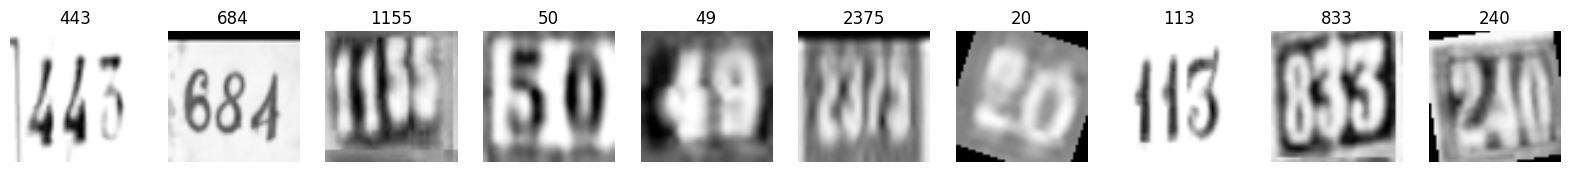

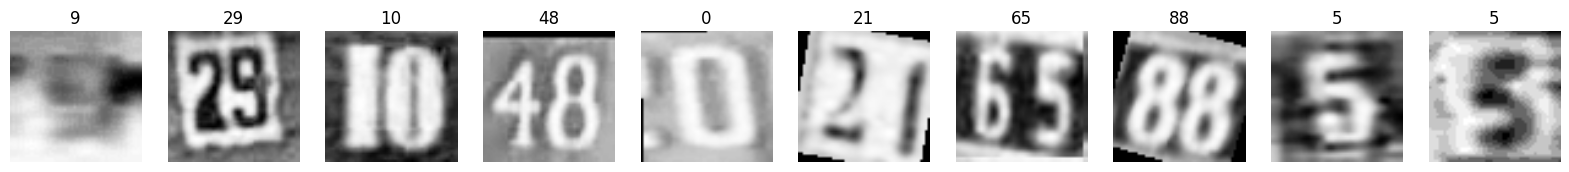

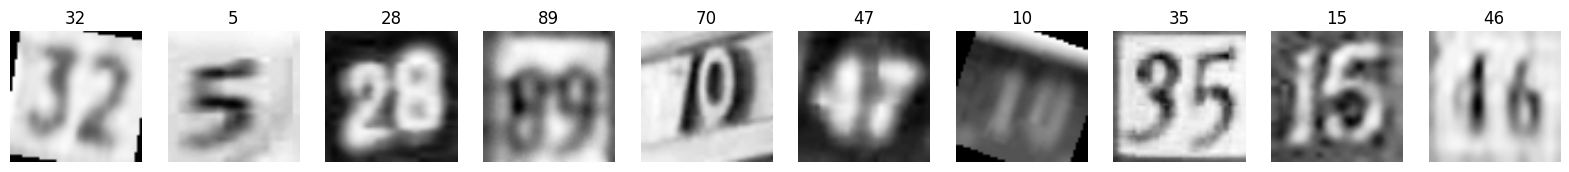

In [11]:
train_dataset_augm,train_labels_augm=generateAugmentedDataSet(train_dataset_t, train_labels_t,3)   

display_images(train_dataset_augm, train_labels_augm)   
valid_dataset_augm, valid_labels_augm=generateAugmentedDataSet(valid_dataset_t, valid_labels_t,1) 
display_images(valid_dataset_augm, valid_labels_augm)  

test_dataset_augm, test_labels_augm=generateAugmentedDataSet(test_dataset_t, test_labels_t,1) 
display_images(test_dataset_augm, test_labels_augm)  

print(len(train_dataset_t),len(train_dataset_augm))
print(len(valid_dataset_t),len(valid_dataset_augm))
print(len(test_dataset_t),len(test_dataset_augm))


In [12]:
print (train_dataset_augm.shape)
print (valid_dataset_augm.shape)
print (test_dataset_augm.shape)

(3681120, 54, 54, 1)
(34104, 54, 54, 1)
(78408, 54, 54, 1)


## Shuffle data sets

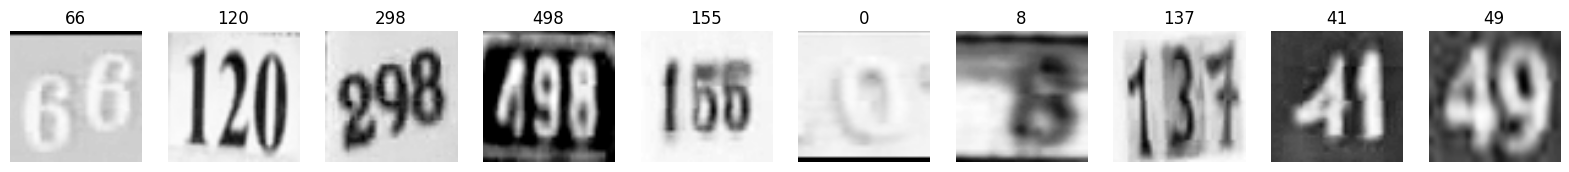

In [13]:
train_dataset = train_dataset_t
train_labels = train_labels_t
valid_dataset = valid_dataset_t
valid_labels = valid_labels_t
test_dataset = test_dataset_t
test_labels = test_labels_t

train_dataset = train_dataset_augm
train_labels = train_labels_augm
#valid_dataset = valid_dataset_augm
#valid_labels = valid_labels_augm
#test_dataset = test_dataset_augm
#test_labels = test_labels_augm

train_dataset,train_labels=shuffle(train_dataset,train_labels)
display_images(train_dataset, train_labels) 

valid_dataset, valid_labels=shuffle(valid_dataset, valid_labels)
display_images(valid_dataset, valid_labels) 

test_dataset, test_labels=shuffle(test_dataset, test_labels)
display_images(test_dataset, test_labels) 

## normalize the images by mean and standard deviation per image


In [15]:
def normalizeImages(dataset):
    for idx in range (0,len(dataset)):
        im= dataset[idx,:,:,0]
        mean=np.mean(im, dtype=np.float64)
        std=np.std(im, dtype=np.float64)
        if std<0.001:
            std=1.0
        im=(im-mean)/std
        dataset[idx,:,:,0]=im



In [16]:
normalizeImages(train_dataset)
normalizeImages(valid_dataset)
normalizeImages(test_dataset)
print (train_dataset.shape)
print (valid_dataset.shape)
print (test_dataset.shape)
print("normalization done")

(3681120, 54, 54, 1)
(5684, 54, 54, 1)
(13068, 54, 54, 1)
normalization done


In [17]:
print (train_dataset.shape)


(3681120, 54, 54, 1)


## plot accuracy and loss

In [18]:
def plot_results(acc_train,acc_valid,losses,ymin=80,ymax=100):
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    matplotlib.rcParams.update({'font.size': 18})
    steps=losses.keys()
    loss=losses.values()
    steps
    dflosses=pd.DataFrame(losses.values(),columns=['Loss'],index=steps)
    dflosses.index.names=['Steps']
    dflosses.plot(figsize=(15,10),ylim=(0.0,2.0),title="Loss")
    dfacc=pd.DataFrame([acc_train.values(),acc_valid.values()])

    dfacc=dfacc.transpose()
    dfacc.columns=['Train Accurary','Validation Accurary']
    dfacc.index=steps
    dfacc.index.names=['Steps']
    dfacc.plot(figsize=(15,10),ylim=(ymin,ymax),title="Accuracy")

# Convolution Network

## Helper functions

In [19]:
# Helper functions
def create_weight_conv(name,shape):
    return tf.get_variable(name, shape,initializer=tf.contrib.layers.xavier_initializer_conv2d())

def create_weight(name,shape):
    return tf.get_variable(name, shape,initializer=tf.contrib.layers.xavier_initializer())

def create_bias(name,shape):
    return tf.Variable(tf.constant(1.0, shape=shape),name=name)


def create_conv_layer(name,data, weights,padding,conv_stride):
    return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

def create_pool_layer(name,data,pool_window_size,padding,pool_stride):
    return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

def get_conv_shape(data_shape, weights_shape,padding,conv_stride):
    if padding == 'VALID':
        new_height = int(np.ceil((1.0*(data_shape[1] - weights_shape[0] + 1)) / conv_stride))
        new_width = int(np.ceil((1.0*(data_shape[2] - weights_shape[1] + 1)) / conv_stride))
    else:
        new_height = int(np.ceil(1.0*data_shape[1]) / conv_stride)
        new_width = int(np.ceil(1.0*data_shape[2] / conv_stride))
    return (data_shape[0], new_height, new_width, weights_shape[3])

def get_pool_shape(data_shape,pool_stride):
    new_height = int(np.ceil(1.0*data_shape[1] / pool_stride[1]))
    new_width = int(np.ceil(1.0*data_shape[2] / pool_stride[2]))
    return (data_shape[0], new_height, new_width, data_shape[3])


# Two fully connected layer, local response normalization before relu¶

Conv ->Conv ->MaxPool-->conv->conv ->maxpool->conv->fully connected1 -> fully connected2 ->logits


In [74]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers, lrn before relu")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
     
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
        lrn1 = tf.nn.local_response_normalization(conv1)
       
        
        conv2 = create_conv_layer('C2',tf.nn.relu(lrn1), conv_2_weights,padconv,conv_stride) + conv_2_biases
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',tf.nn.relu(lrn2),pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
        lrn3 = tf.nn.local_response_normalization(conv3)
      
        
        conv4 = create_conv_layer('C4',tf.nn.relu(lrn3), conv_4_weights,padconv,conv_stride) + conv_4_biases
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',tf.nn.relu(lrn4),pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
        lrn5 = tf.nn.local_response_normalization(conv5)
        pool5 = create_pool_layer('P5',tf.nn.relu(lrn5),pool_window_size,padpool,pool_stride)
   
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
     
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
      # Predictions for the training, validation, and test data.

      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [27]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2.ckpt"


#---------------------now 54x54 images ----------------
# tf.train.AdamOptimizer(learning_rate).minimize(loss) 
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*4
topology_params['num_hidden2']=64*6

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.83%
#====> Test accuracy: 93.24%
# large overfitting, train acc~98%, validation accuracy ~ 91%

#####################################
# now without data augmentation
#====> Test accuracy character level: 97.33%
#====> Test accuracy: 91.48%

###############################
# with data augmentation much higher accurcacy
#====> Test accuracy character level: 97.89%
#====> Test accuracy: 93.52%

#########################################
#adding two dropout imn conv layers
#====> Test accuracy character level: 98.06%
#====> Test accuracy: 94.12% !!!!
# overfitting reduced train-acc ~9.5 validation acc ~91.5%
#Model saved in file: CNN_multi_deep_ful2.ckpt
# Model renamed CNN_multi_deep_ful2_94_12.ckpt

acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers, lrn before relu
cv1 (128, 54, 54, 32)
cv2 (128, 54, 54, 64)
p2 (128, 27, 27, 64)
cv3 (128, 27, 27, 128)
cv4 (128, 27, 27, 128)
p4 (128, 14, 14, 128)
cv5 (128, 14, 14, 256)
p5 (128, 7, 7, 256)
ff 12544
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 34.193657
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 14.49%
Minibatch loss at step 2500: 8.002213
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 5000: 7.478100
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 7500: 5.499571
Minibatch accuracy: 12.50%
Validation accuracy: 19.60%
Validation accuracy character level: 69.96%
Minibatch loss at step 10000: 3.414116
Minibatch accuracy: 53.91%
Validation accuracy: 56.98%
Validation accuracy chara

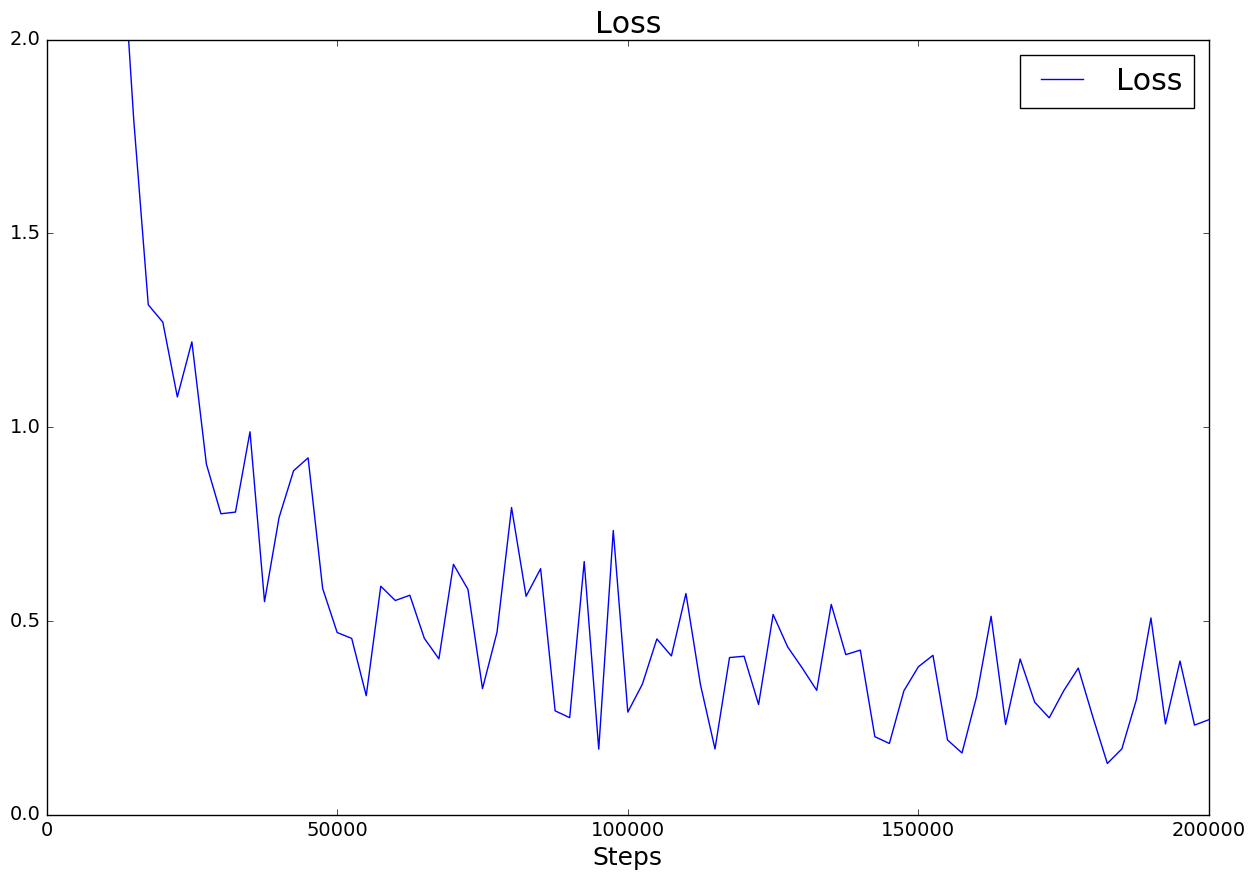

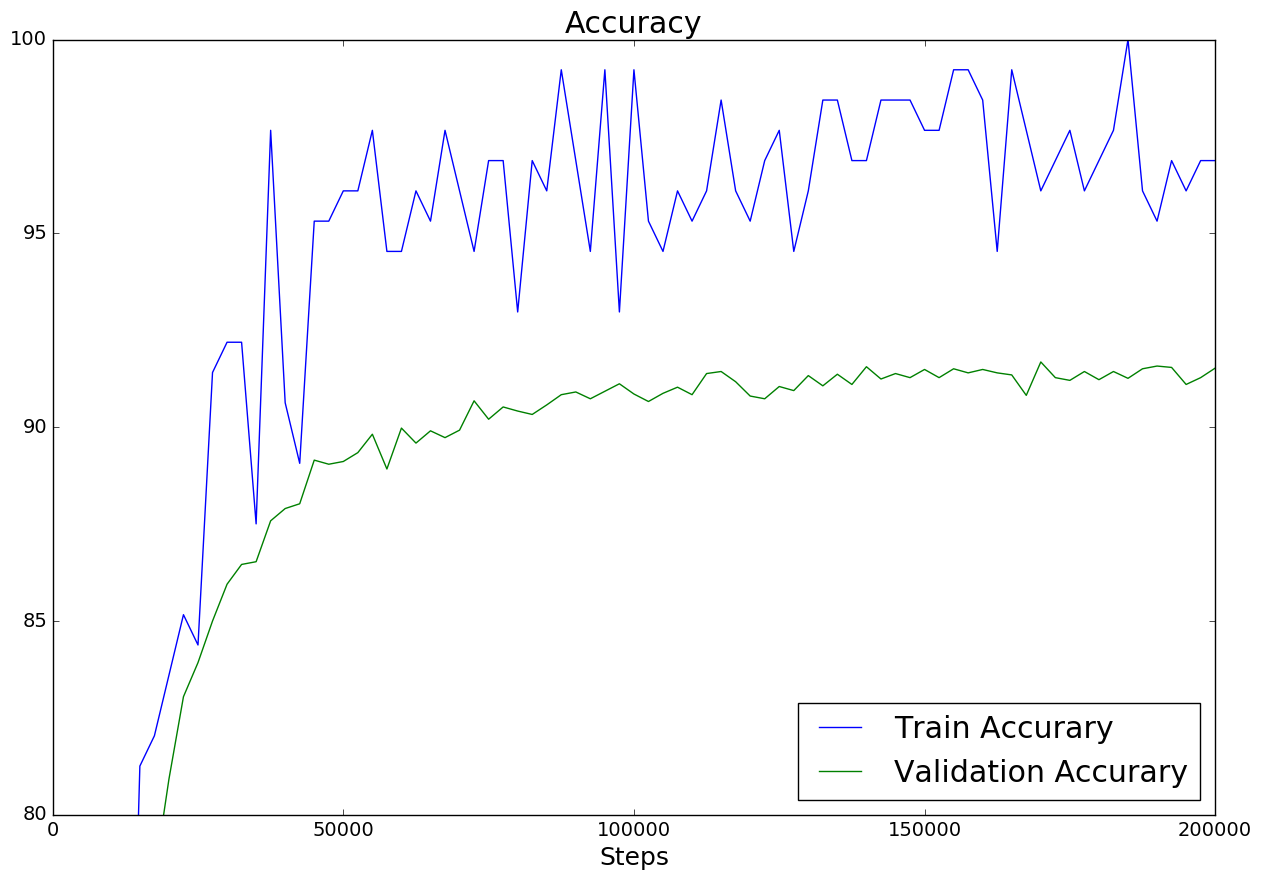

In [28]:
plot_results(acc_train,acc_valid,losses)

# Two fully connected layer, local response normalization before relu dropout in every conv layer to reduce overfitting¶

Conv ->Conv ->MaxPool-->conv->conv ->maxpool->conv->fully connected1 -> fully connected2 ->logits


In [76]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers, lrn before relu, dropout in every conv layer")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
     
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
        lrn1 = tf.nn.relu(tf.nn.local_response_normalization(conv1))
        lrn1=tf.nn.dropout(lrn1, keep_prob)
        
        conv2 = create_conv_layer('C2',lrn1, conv_2_weights,padconv,conv_stride) + conv_2_biases
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',tf.nn.relu(lrn2),pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
        lrn3 = tf.nn.relu(tf.nn.local_response_normalization(conv3))
        lrn3=tf.nn.dropout(lrn3, keep_prob)
        
        conv4 = create_conv_layer('C4',lrn3, conv_4_weights,padconv,conv_stride) + conv_4_biases
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',tf.nn.relu(lrn4),pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
        lrn5 = tf.nn.local_response_normalization(conv5)
        pool5 = create_pool_layer('P5',tf.nn.relu(lrn5),pool_window_size,padpool,pool_stride)
        pool5=tf.nn.dropout(pool5, keep_prob)
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses 

In [72]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2_dropconv.ckpt"


#########################################
#adding  dropout in all conv layers
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*4
topology_params['num_hidden2']=64*6

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 98.04%
#====> Test accuracy: 93.92%
#overfitting further reduced train acc ~96%, validation acc ~ 91.6%
#maybe more steps required!

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*8

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.99%
#====> Test accuracy: 93.86%
# large overfitting
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers, lrn before relu, dropout in every conv layer
cv1 (128, 54, 54, 32)
cv2 (128, 54, 54, 64)
p2 (128, 27, 27, 64)
cv3 (128, 27, 27, 128)
cv4 (128, 27, 27, 128)
p4 (128, 14, 14, 128)
cv5 (128, 14, 14, 768)
p5 (128, 7, 7, 768)
ff 37632
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 29.696003
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.33%
Minibatch loss at step 2500: 8.015112
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 5000: 7.483198
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 7500: 8.001812
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 10000: 7.831554
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%


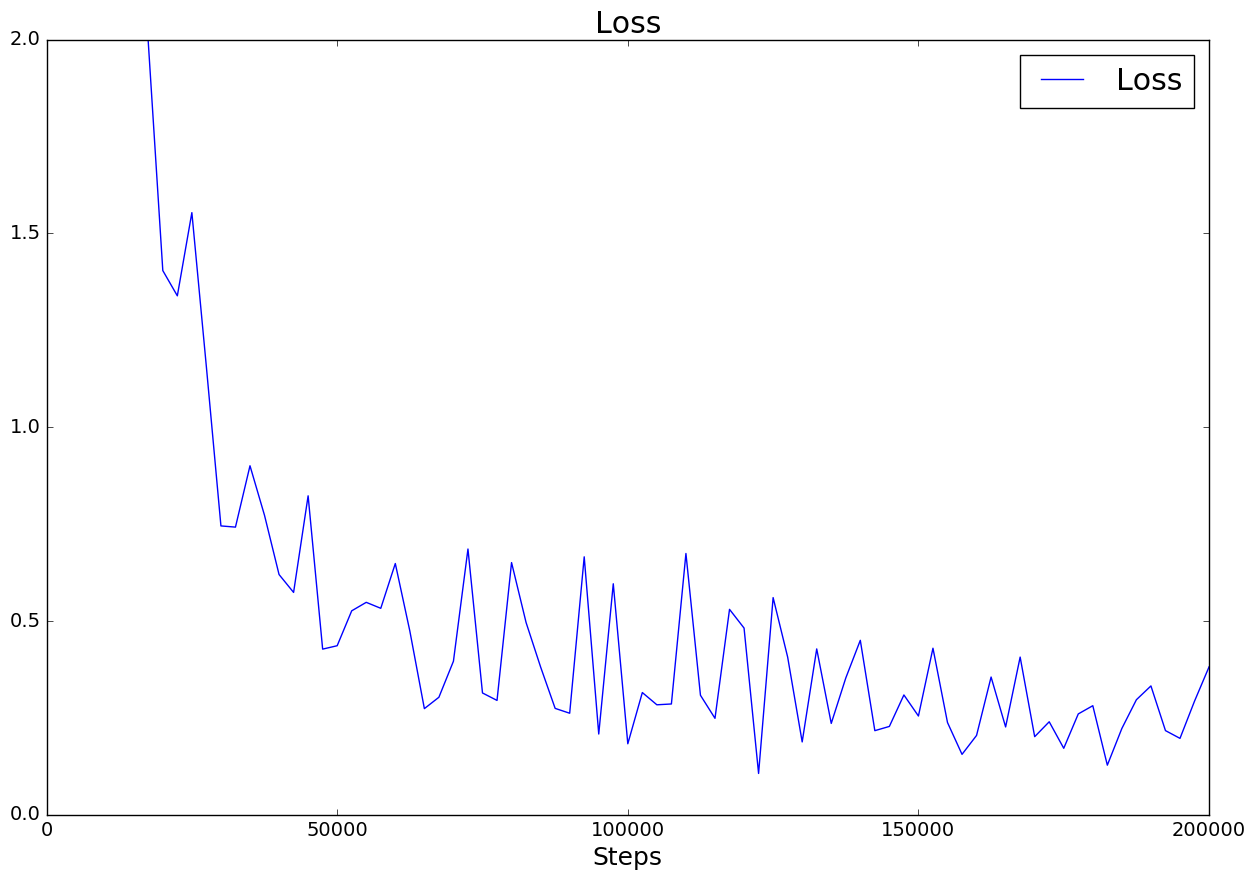

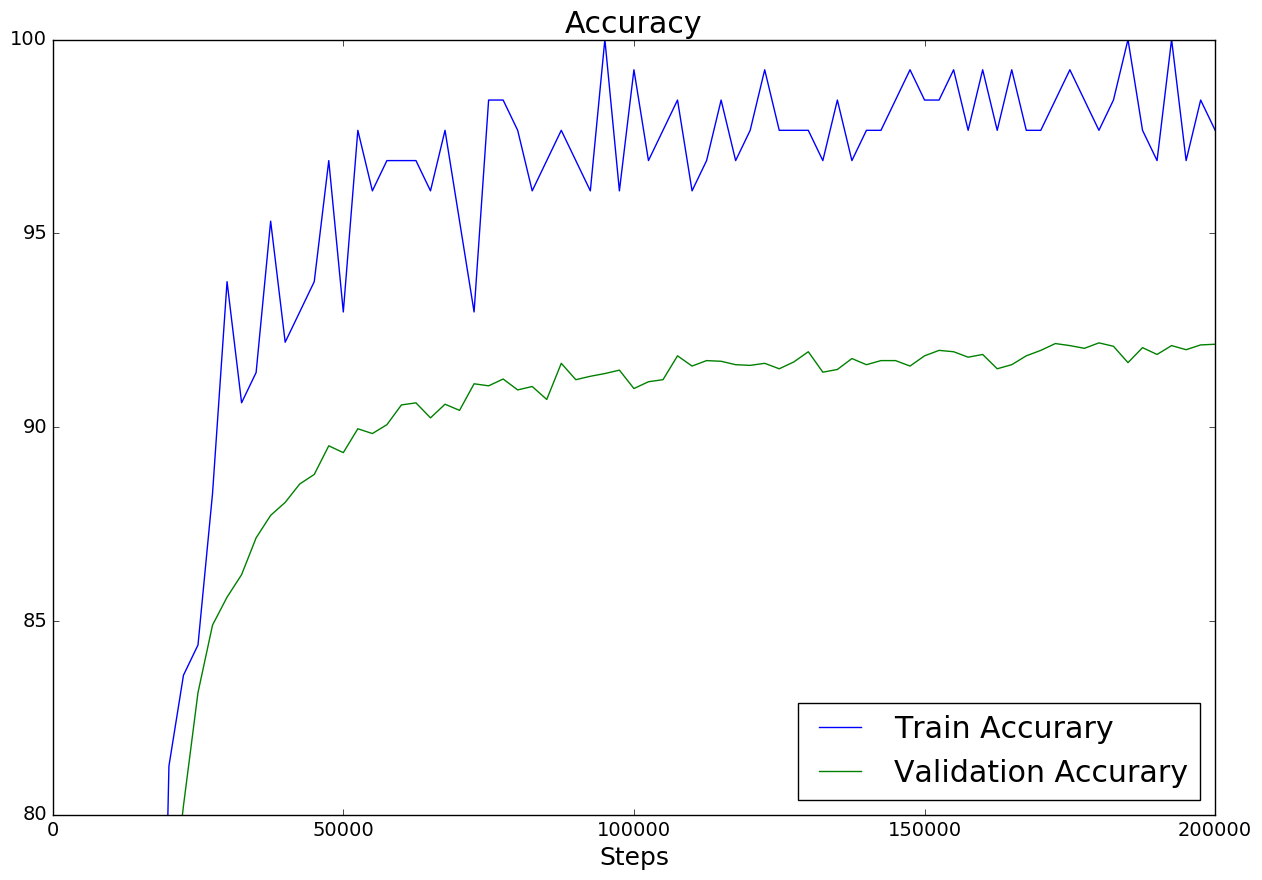

In [73]:
plot_results(acc_train,acc_valid,losses)

# LRN after relu, two dropouts in conv layers

In [78]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers, lrn after relu, dropout in two conv layer")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
     
        conv1 = tf.nn.relu(create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases)
        lrn1 = tf.nn.local_response_normalization(conv1)
     #   lrn1=tf.nn.dropout(lrn1, keep_prob)
        
        conv2 = tf.nn.relu(create_conv_layer('C2',lrn1, conv_2_weights,padconv,conv_stride) + conv_2_biases)
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',lrn2,pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = tf.nn.relu(create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases)
        lrn3 = tf.nn.local_response_normalization(conv3)
     #   lrn3=tf.nn.dropout(lrn3, keep_prob)
        
        conv4 = tf.nn.relu(create_conv_layer('C4',lrn3, conv_4_weights,padconv,conv_stride) + conv_4_biases)
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',lrn4,pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = tf.nn.relu(create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases)
        lrn5 = tf.nn.local_response_normalization(conv5)
        pool5 = create_pool_layer('P5',lrn5,pool_window_size,padpool,pool_stride)
     #   pool5=tf.nn.dropout(pool5, keep_prob)
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
   
      # Predictions for the training, validation, and test data.
      
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [59]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2_lrn_after_relu-dropconv.ckpt"


#---------------------now 54x54 images ----------------
# tf.train.AdamOptimizer(learning_rate).minimize(loss) 

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*4
topology_params['num_hidden2']=64*6

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.32%
#====> Test accuracy: 92.17% !!! 2% lower as with lrn before relu!!! Overfitting bit lower: train acc ~95% val acc ~90%


acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers, lrn after relu, dropout in two conv layer
cv1 (128, 54, 54, 32)
cv2 (128, 54, 54, 64)
p2 (128, 27, 27, 64)
cv3 (128, 27, 27, 128)
cv4 (128, 27, 27, 128)
p4 (128, 14, 14, 128)
cv5 (128, 14, 14, 256)
p5 (128, 7, 7, 256)
ff 12544
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 32.167019
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 16.91%
Minibatch loss at step 2500: 8.087671
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 5000: 7.529240
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 7500: 8.006552
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 10000: 7.806480
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Val

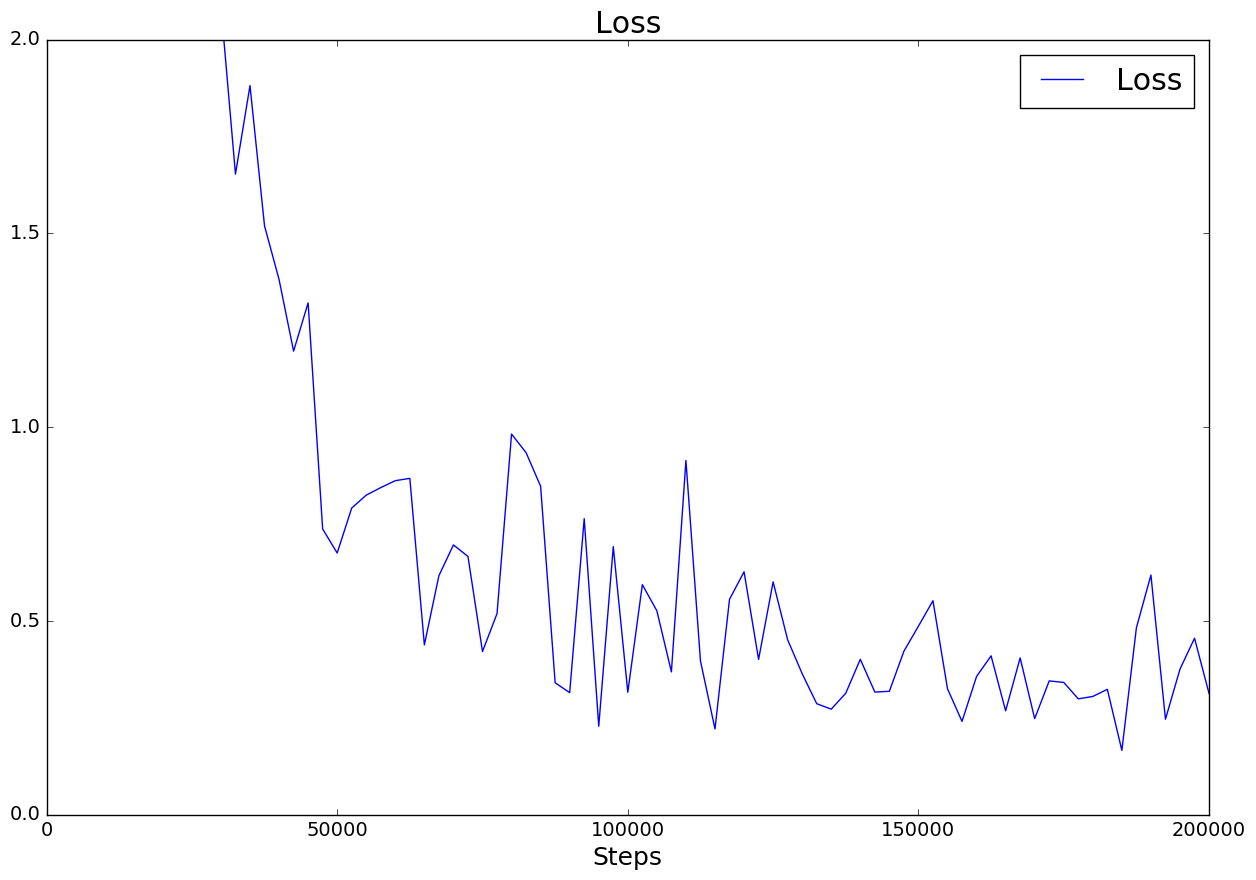

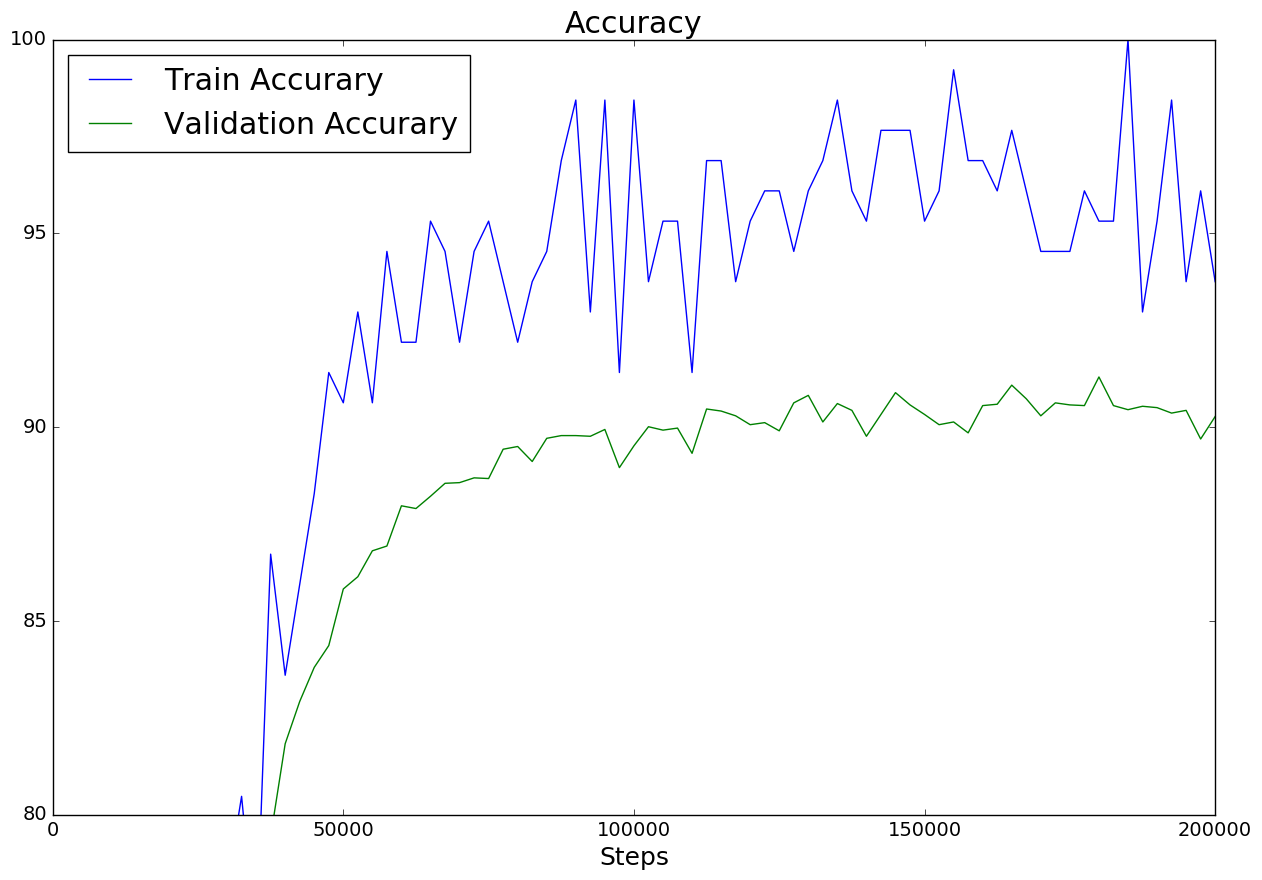

In [60]:
plot_results(acc_train,acc_valid,losses)

# No lrn but dropout in conv layers
Conv ->Conv ->MaxPool-->conv->conv ->maxpool->conv->fully connected1 -> fully connected2 ->logits


In [80]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers, no relu")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
     
        conv1 = tf.nn.relu(create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases)
        conv1=tf.nn.dropout(conv1, keep_prob)
             
        conv2 = tf.nn.relu(create_conv_layer('C2',conv1, conv_2_weights,padconv,conv_stride) + conv_2_biases)
        pool2 = create_pool_layer('P2',conv2,pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = tf.nn.relu(create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases)
        conv3=tf.nn.dropout(conv3, keep_prob)
        
        conv4 = tf.nn.relu(create_conv_layer('C4',conv3, conv_4_weights,padconv,conv_stride) + conv_4_biases)
   
        pool4 = create_pool_layer('P4',conv4,pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = tf.nn.relu(create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases)
        pool5 = create_pool_layer('P5',conv5,pool_window_size,padpool,pool_stride)
        pool5=tf.nn.dropout(pool5, keep_prob)
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [68]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2_nolrn.ckpt"


#---------------------now 54x54 images ----------------
# tf.train.AdamOptimizer(learning_rate).minimize(loss) 
topology_params['patch_size1']=5

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*4
topology_params['num_hidden2']=64*6

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.04%
#====> Test accuracy: 93.85%
# quite large overfitting

# now dropout in all conv layer

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 98.03%
#====> Test accuracy: 94.03% !
#overfitting lower train acc ~96%, val acc ~92%

#try more steps
learning_params['num_steps']=400001
#====> Test accuracy character level: 98.02%
#====> Test accuracy: 94.12%
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers, no relu
cv1 (128, 54, 54, 32)
cv2 (128, 54, 54, 64)
p2 (128, 27, 27, 64)
cv3 (128, 27, 27, 128)
cv4 (128, 27, 27, 128)
p4 (128, 14, 14, 128)
cv5 (128, 14, 14, 256)
p5 (128, 7, 7, 256)
ff 12544
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 131.363556
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 36.58%
Minibatch loss at step 2500: 8.041257
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.33%
Minibatch loss at step 5000: 7.497995
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.34%
Minibatch loss at step 7500: 8.093470
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 10000: 5.972580
Minibatch accuracy: 4.69%
Validation accuracy: 6.40%
Validation accuracy character level:

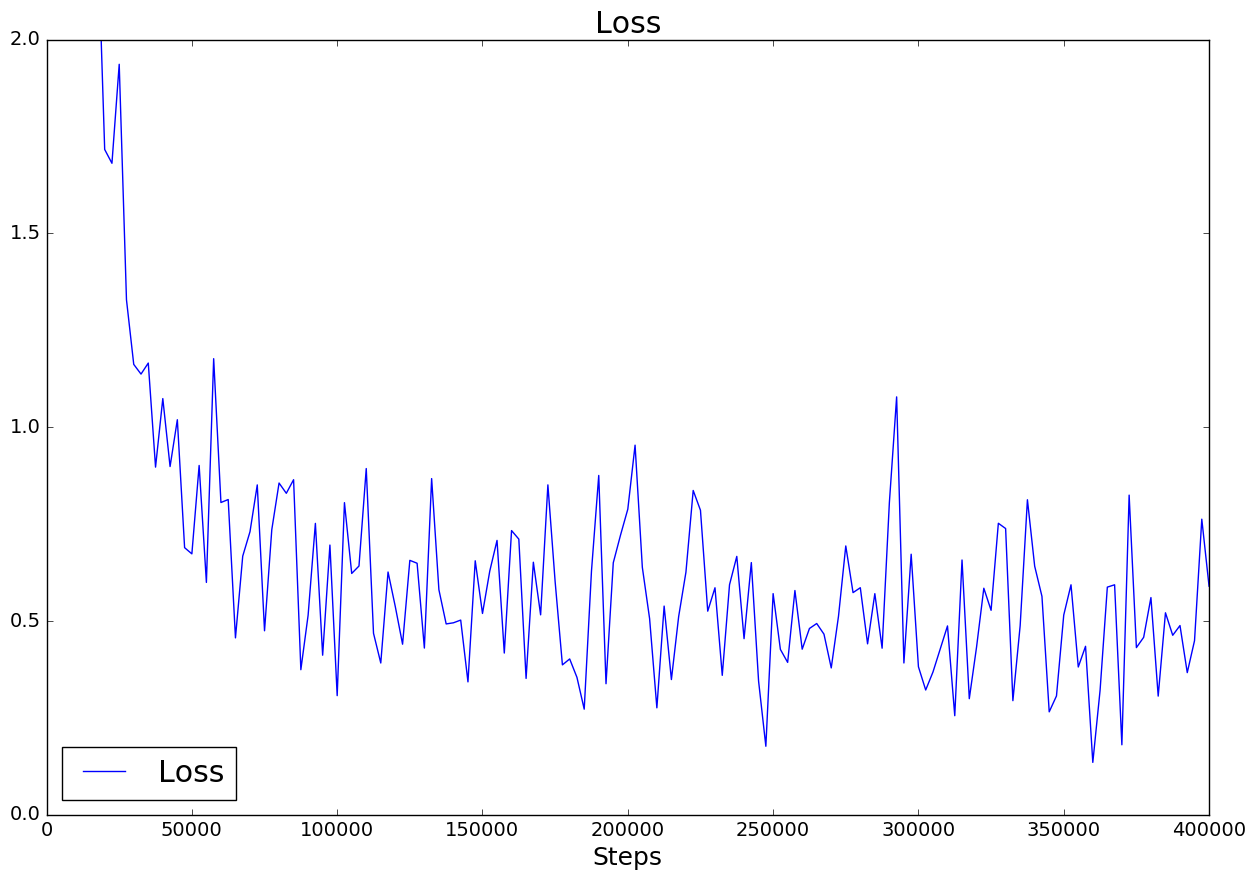

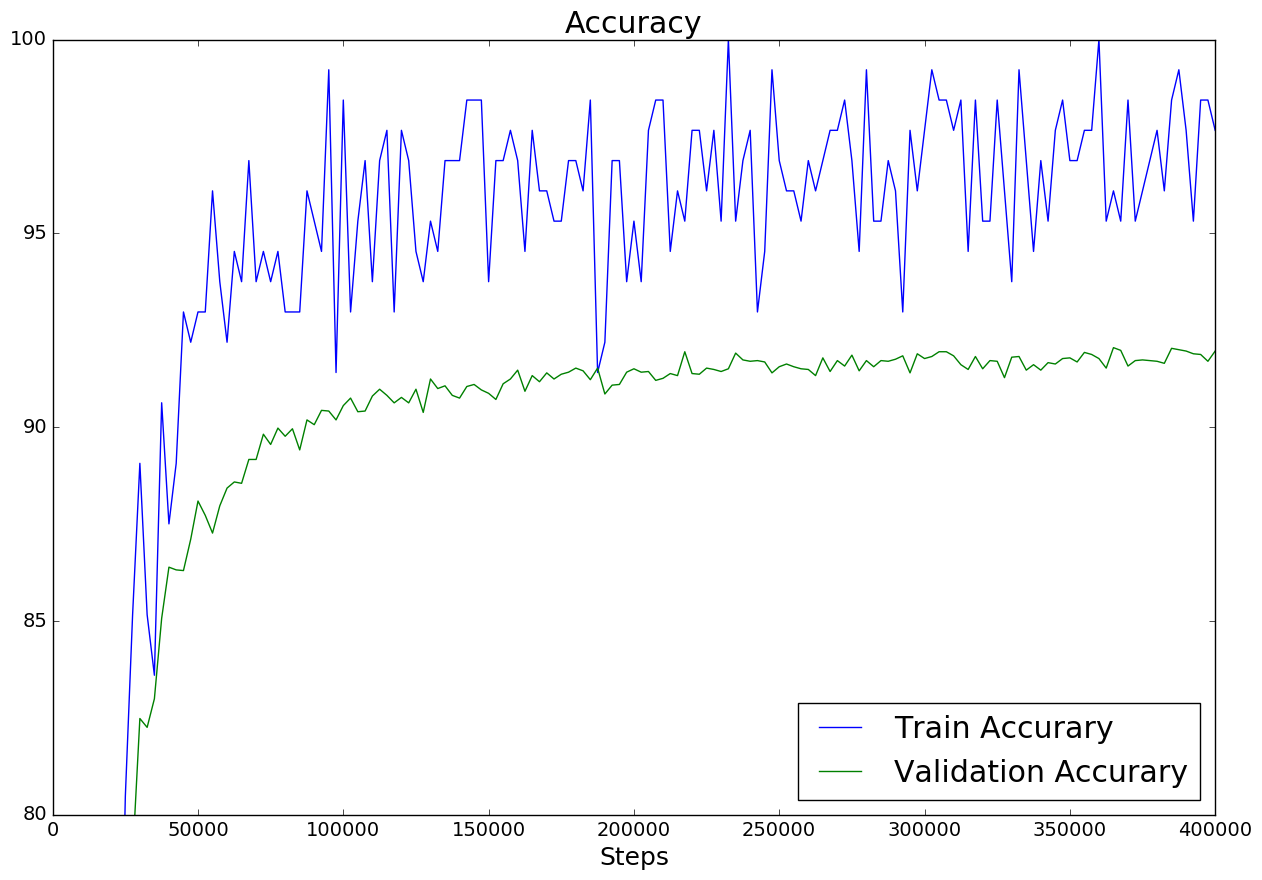

In [69]:
plot_results(acc_train,acc_valid,losses)

# very deep network lrn before relu,  dropout every second conv layer

Conv -> Max Pool (stride2) -> Conv ->MaxPool (stride1)-> Conv ->MaxPool(stride2)-> Conv ->MaxPool(stride1)-> Conv ->MaxPool(stride2)-> Conv ->MaxPool(stride1)-> Conv ->MaxPool(Stride2)-> Conv ->fully connected->fully connected->logits 

In [113]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("very deep CNN")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride1 = [1, 1, 1, 1]
    pool_stride2 = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    depth6 = topology_params['depth6']
    depth7 = topology_params['depth7']
    depth8 = topology_params['depth8']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

  
 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate'] 
    
    
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
      pool_1_shape = get_pool_shape(conv_1_shape,pool_stride2)
    
      print("cv1",conv_1_shape)
      print("p1",pool_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(pool_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride1)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
      pool_3_shape = get_pool_shape(conv_3_shape,pool_stride2)
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(pool_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride1)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, depth5])
      conv_5_biases = create_bias('B5',shape=[depth5])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride2)
    
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      # Sixth convolution layer 
      conv_6_weights = create_weight_conv("W6",shape=[patch_size2, patch_size2, depth5, depth6])
      conv_6_biases = create_bias('B6',shape=[depth6])
      conv_6_shape = get_conv_shape(pool_5_shape, conv_6_weights.get_shape().as_list(),padconv,conv_stride)
      pool_6_shape = get_pool_shape(conv_6_shape,pool_stride1)
    
      print("cv6",conv_6_shape)
      print("p6",pool_6_shape)
    
      # Seventh convolution layer 
      conv_7_weights = create_weight_conv("W7",shape=[patch_size2, patch_size2, depth6, depth7])
      conv_7_biases = create_bias('B7',shape=[depth7])
      conv_7_shape = get_conv_shape(pool_6_shape, conv_7_weights.get_shape().as_list(),padconv,conv_stride)
      pool_7_shape = get_pool_shape(conv_7_shape,pool_stride2)
    
      print("cv7",conv_7_shape)
      print("p7",pool_7_shape)
    
     # eight convolution layer 
      conv_8_weights = create_weight_conv("W8",shape=[patch_size2, patch_size2, depth7, num_hidden1])
      conv_8_biases = create_bias('B8',shape=[num_hidden1])
      conv_8_shape = get_conv_shape(pool_7_shape, conv_8_weights.get_shape().as_list(),padconv,conv_stride)
      pool_8_shape = get_pool_shape(conv_8_shape,pool_stride1)
         
      print("cv8",conv_8_shape)
      print("p8",pool_8_shape)
    
      #Frist fully connected layer
      final_shape=pool_8_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
        lrn1 = tf.nn.local_response_normalization(conv1)
        pool1 = create_pool_layer('P1', tf.nn.relu(lrn1),pool_window_size,padpool,pool_stride2)
      
        
        conv2 = create_conv_layer('C2',pool1, conv_2_weights,padconv,conv_stride) + conv_2_biases
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',tf.nn.relu(lrn2),pool_window_size,padpool,pool_stride1)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
        lrn3 = tf.nn.local_response_normalization(conv3)
        pool3 = create_pool_layer('P3',tf.nn.relu(lrn3),pool_window_size,padpool,pool_stride2)

        
        conv4 = create_conv_layer('C4',pool3, conv_4_weights,padconv,conv_stride) + conv_4_biases
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',tf.nn.relu(lrn4),pool_window_size,padpool,pool_stride1)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
        lrn5 = tf.nn.local_response_normalization(conv5)
        pool5 = create_pool_layer('P5',tf.nn.relu(lrn5),pool_window_size,padpool,pool_stride2)
     
        
        conv6 = create_conv_layer('C6',pool5, conv_6_weights,padconv,conv_stride) + conv_6_biases
        lrn6 = tf.nn.local_response_normalization(conv6)
        pool6 = create_pool_layer('P6',tf.nn.relu(lrn6),pool_window_size,padpool,pool_stride1)
     #   pool6=tf.nn.dropout(pool6, keep_prob)
        
        conv7 = create_conv_layer('C7',pool6, conv_7_weights,padconv,conv_stride) + conv_7_biases
        lrn7 = tf.nn.local_response_normalization(conv7)
        pool7 = create_pool_layer('P7',tf.nn.relu(lrn7),pool_window_size,padpool,pool_stride2)        
        
       
        conv8 = create_conv_layer('C8',pool7, conv_8_weights,padconv,conv_stride) + conv_8_biases
        lrn8 = tf.nn.local_response_normalization(conv8)
        pool8 = create_pool_layer('P8',tf.nn.relu(lrn8),pool_window_size,padpool,pool_stride1)      
    #    pool8=tf.nn.dropout(pool8, keep_prob)
        
        last=pool8  #<-------!!
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]


      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
     
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    
      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
 
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            losses[step]=l
            acc_train[step]=trainacc
             
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [114]:


datasets={}
topology_params={}
learning_params={} 
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_8conv.ckpt"



#   optimizer = tf.train.AdamOptimizer(v).minimize(loss)
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=64
topology_params['depth5']=64*2
topology_params['depth6']=64*2
topology_params['depth7']=64*3
topology_params['depth8']=64*3
topology_params['num_hidden1']=64*6
topology_params['num_hidden2']=64*6


learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 97.49%
#====> Test accuracy: 92.54%
#large overfitting train acc ~97%, valid acc ~91.5%

acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

very deep CNN
cv1 (128, 54, 54, 32)
p1 (128, 27, 27, 32)
cv2 (128, 27, 27, 32)
p2 (128, 27, 27, 32)
cv3 (128, 27, 27, 64)
cv4 (128, 14, 14, 64)
p4 (128, 14, 14, 64)
cv5 (128, 14, 14, 128)
p5 (128, 7, 7, 128)
cv6 (128, 7, 7, 128)
p6 (128, 7, 7, 128)
cv7 (128, 7, 7, 192)
p7 (128, 4, 4, 192)
cv8 (128, 4, 4, 384)
p8 (128, 4, 4, 384)
ff 6144
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 27.988483
Minibatch accuracy: 0.00%
Validation accuracy: 0.02%
Validation accuracy character level: 28.07%
Minibatch loss at step 2500: 7.961083
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 5000: 7.490017
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 7500: 8.037821
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 10000: 6.90359

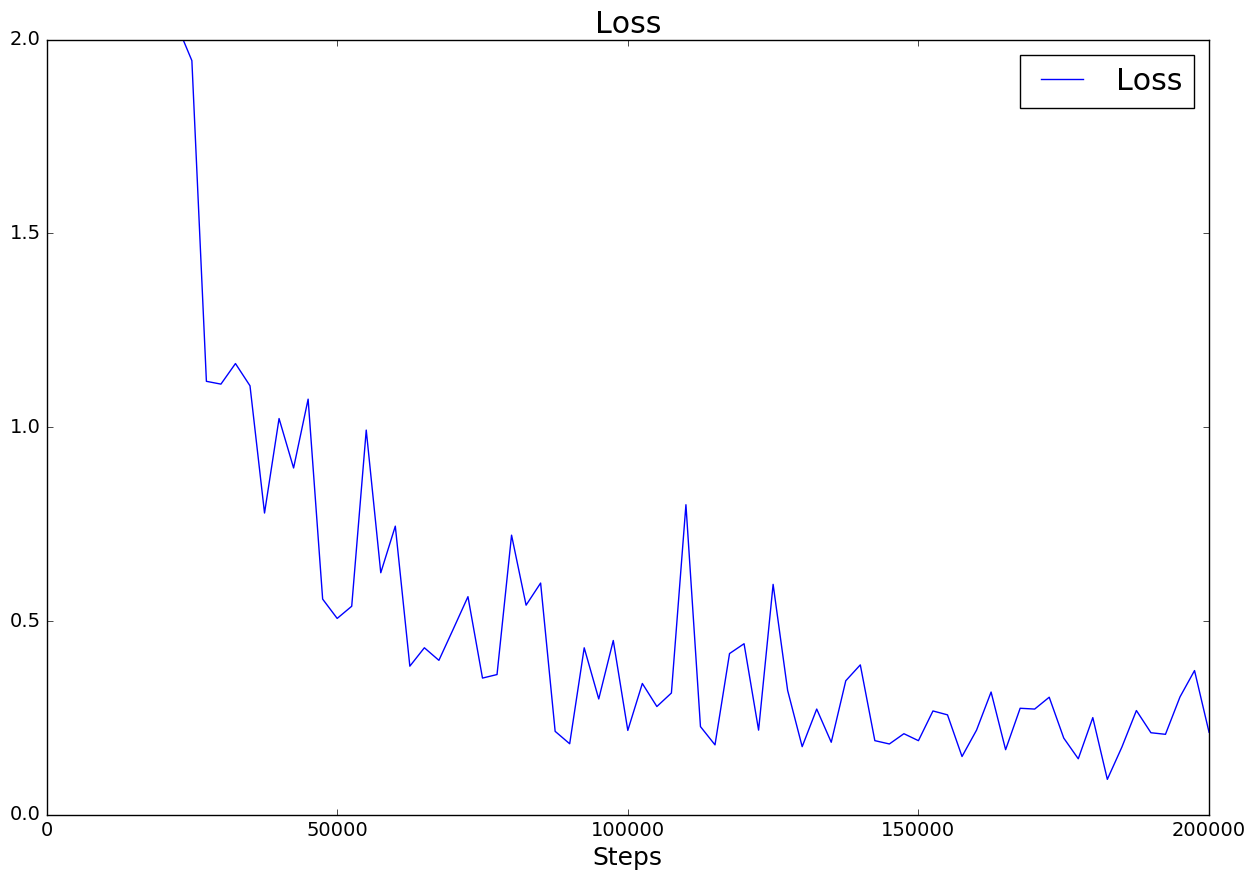

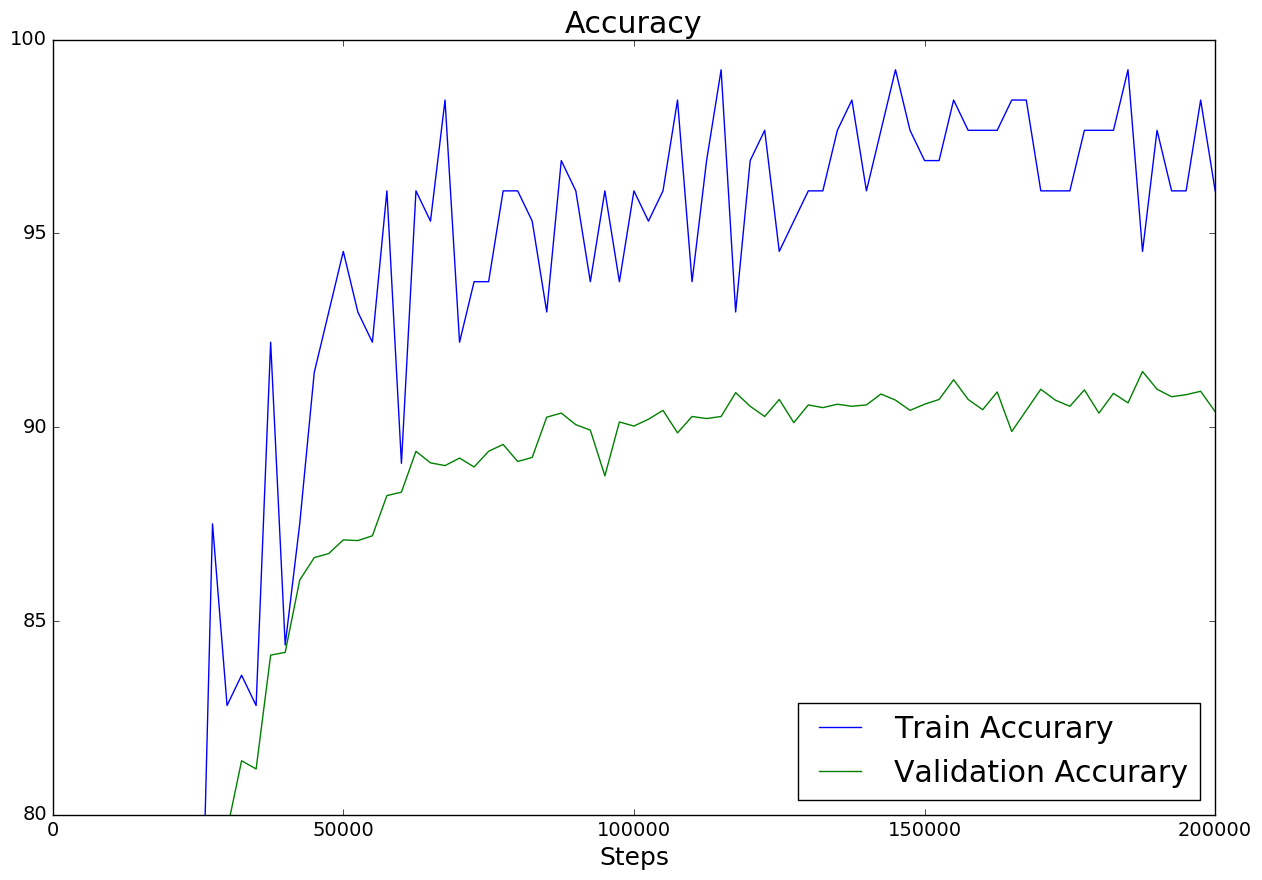

In [115]:
plot_results(acc_train,acc_valid,losses)

# very deep network without lrn, dropout every second conv layer, elu activation¶

Conv -> Max Pool (stride2) -> Conv ->MaxPool (stride1)-> Conv ->MaxPool(stride2)-> Conv ->MaxPool(stride1)-> Conv ->MaxPool(stride2)-> Conv ->MaxPool(stride1)-> Conv ->MaxPool(Stride2)-> Conv ->fully connected->fully connected->logits


In [22]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("very deep CNN no lrn elu instead of relu")
    image_size = 54
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride1 = [1, 1, 1, 1]
    pool_stride2 = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    depth6 = topology_params['depth6']
    depth7 = topology_params['depth7']
    depth8 = topology_params['depth8']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

  
 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate'] 
    
    
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
      pool_1_shape = get_pool_shape(conv_1_shape,pool_stride2)
    
      print("cv1",conv_1_shape)
      print("p1",pool_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(pool_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride1)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
      pool_3_shape = get_pool_shape(conv_3_shape,pool_stride2)
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(pool_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride1)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, depth5])
      conv_5_biases = create_bias('B5',shape=[depth5])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride2)
    
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      # Sixth convolution layer 
      conv_6_weights = create_weight_conv("W6",shape=[patch_size2, patch_size2, depth5, depth6])
      conv_6_biases = create_bias('B6',shape=[depth6])
      conv_6_shape = get_conv_shape(pool_5_shape, conv_6_weights.get_shape().as_list(),padconv,conv_stride)
      pool_6_shape = get_pool_shape(conv_6_shape,pool_stride1)
    
      print("cv6",conv_6_shape)
      print("p6",pool_6_shape)
    
      # Seventh convolution layer 
      conv_7_weights = create_weight_conv("W7",shape=[patch_size2, patch_size2, depth6, depth7])
      conv_7_biases = create_bias('B7',shape=[depth7])
      conv_7_shape = get_conv_shape(pool_6_shape, conv_7_weights.get_shape().as_list(),padconv,conv_stride)
      pool_7_shape = get_pool_shape(conv_7_shape,pool_stride2)
    
      print("cv7",conv_7_shape)
      print("p7",pool_7_shape)
    
     # eight convolution layer 
      conv_8_weights = create_weight_conv("W8",shape=[patch_size2, patch_size2, depth7, num_hidden1])
      conv_8_biases = create_bias('B8',shape=[num_hidden1])
      conv_8_shape = get_conv_shape(pool_7_shape, conv_8_weights.get_shape().as_list(),padconv,conv_stride)
      pool_8_shape = get_pool_shape(conv_8_shape,pool_stride1)
         
      print("cv8",conv_8_shape)
      print("p8",pool_8_shape)
    
      #Frist fully connected layer
      final_shape=pool_8_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
       
        pool1 = create_pool_layer('P1', tf.nn.elu(conv1),pool_window_size,padpool,pool_stride2)
      
        
        conv2 = create_conv_layer('C2',pool1, conv_2_weights,padconv,conv_stride) + conv_2_biases
       
        pool2 = create_pool_layer('P2',tf.nn.elu(conv2),pool_window_size,padpool,pool_stride1)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
       
        pool3 = create_pool_layer('P3',tf.nn.elu(conv3),pool_window_size,padpool,pool_stride2)

        
        conv4 = create_conv_layer('C4',pool3, conv_4_weights,padconv,conv_stride) + conv_4_biases
        
        pool4 = create_pool_layer('P4',tf.nn.elu(conv4),pool_window_size,padpool,pool_stride1)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
       
        pool5 = create_pool_layer('P5',tf.nn.elu(conv5),pool_window_size,padpool,pool_stride2)
     
        
        conv6 = create_conv_layer('C6',pool5, conv_6_weights,padconv,conv_stride) + conv_6_biases
       
        pool6 = create_pool_layer('P6',tf.nn.elu(conv6),pool_window_size,padpool,pool_stride1)
    #    pool6=tf.nn.dropout(pool6, keep_prob)
        
        conv7 = create_conv_layer('C7',pool6, conv_7_weights,padconv,conv_stride) + conv_7_biases
       
        pool7 = create_pool_layer('P7',tf.nn.elu(conv7),pool_window_size,padpool,pool_stride2)        
        
       
        conv8 = create_conv_layer('C8',pool7, conv_8_weights,padconv,conv_stride) + conv_8_biases
       
        pool8 = create_pool_layer('P8',tf.nn.elu(conv8),pool_window_size,padpool,pool_stride1)      
        pool8=tf.nn.dropout(pool8, keep_prob)
        
        last=pool8  #<-------!!
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]


      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
     
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))
    
      # Optimizer.
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
 
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            losses[step]=l
            acc_train[step]=trainacc
             
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in xrange(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in xrange(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [27]:


datasets={}
topology_params={}
learning_params={} 
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_8conv_nolrn.ckpt"



#   optimizer = tf.train.AdamOptimizer(v).minimize(loss)
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=64
topology_params['depth5']=64*2
topology_params['depth6']=64*2
topology_params['depth7']=64*3
topology_params['depth8']=64*3
topology_params['num_hidden1']=64*6
topology_params['num_hidden2']=64*6


learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 97.96%
#====> Test accuracy: 93.50%
# train acc ~ 97.5% val acc ~ 91.5%

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32*2
topology_params['depth3']=64
topology_params['depth4']=64*2
topology_params['depth5']=64*3
topology_params['depth6']=64*3
topology_params['depth7']=64*4
topology_params['depth8']=64*4
topology_params['num_hidden1']=64*8
topology_params['num_hidden2']=64*8


learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.65%
#====> Test accuracy: 93.09%
# large overfitting, train acc  97.5% val acc ~ 91.5%

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=64
topology_params['depth5']=64*2
topology_params['depth6']=64*2
topology_params['depth7']=64*2
topology_params['depth8']=64*2
topology_params['num_hidden1']=64*8
topology_params['num_hidden2']=64*8

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.86%
#====> Test accuracy: 93.63%
#overfitting train  acc ~97% val acc  ~ 91.5%
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=64
topology_params['depth5']=64*2
topology_params['depth6']=64*2
topology_params['depth7']=64*4
topology_params['depth8']=64*4
topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.76%
#====> Test accuracy: 93.01%
#large overfittinhg

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=32
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=64
topology_params['depth5']=64*2
topology_params['depth6']=64*2
topology_params['depth7']=64*2
topology_params['depth8']=64*2
topology_params['num_hidden1']=64*16
topology_params['num_hidden2']=64*16

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.84%
#====> Test accuracy: 93.28%
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

very deep CNN no lrn elu instead of relu
cv1 (128, 54, 54, 32)
p1 (128, 27, 27, 32)
cv2 (128, 27, 27, 32)
p2 (128, 27, 27, 32)
cv3 (128, 27, 27, 64)
cv4 (128, 14, 14, 64)
p4 (128, 14, 14, 64)
cv5 (128, 14, 14, 128)
p5 (128, 7, 7, 128)
cv6 (128, 7, 7, 128)
p6 (128, 7, 7, 128)
cv7 (128, 7, 7, 128)
p7 (128, 4, 4, 128)
cv8 (128, 4, 4, 1024)
p8 (128, 4, 4, 1024)
ff 16384
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 58.527618
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.10%
Minibatch loss at step 2500: 8.224024
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.57%
Minibatch loss at step 5000: 7.764345
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.54%
Minibatch loss at step 7500: 6.323077
Minibatch accuracy: 5.47%
Validation accuracy: 4.87%
Validation accuracy character level: 57.47%
Minibat

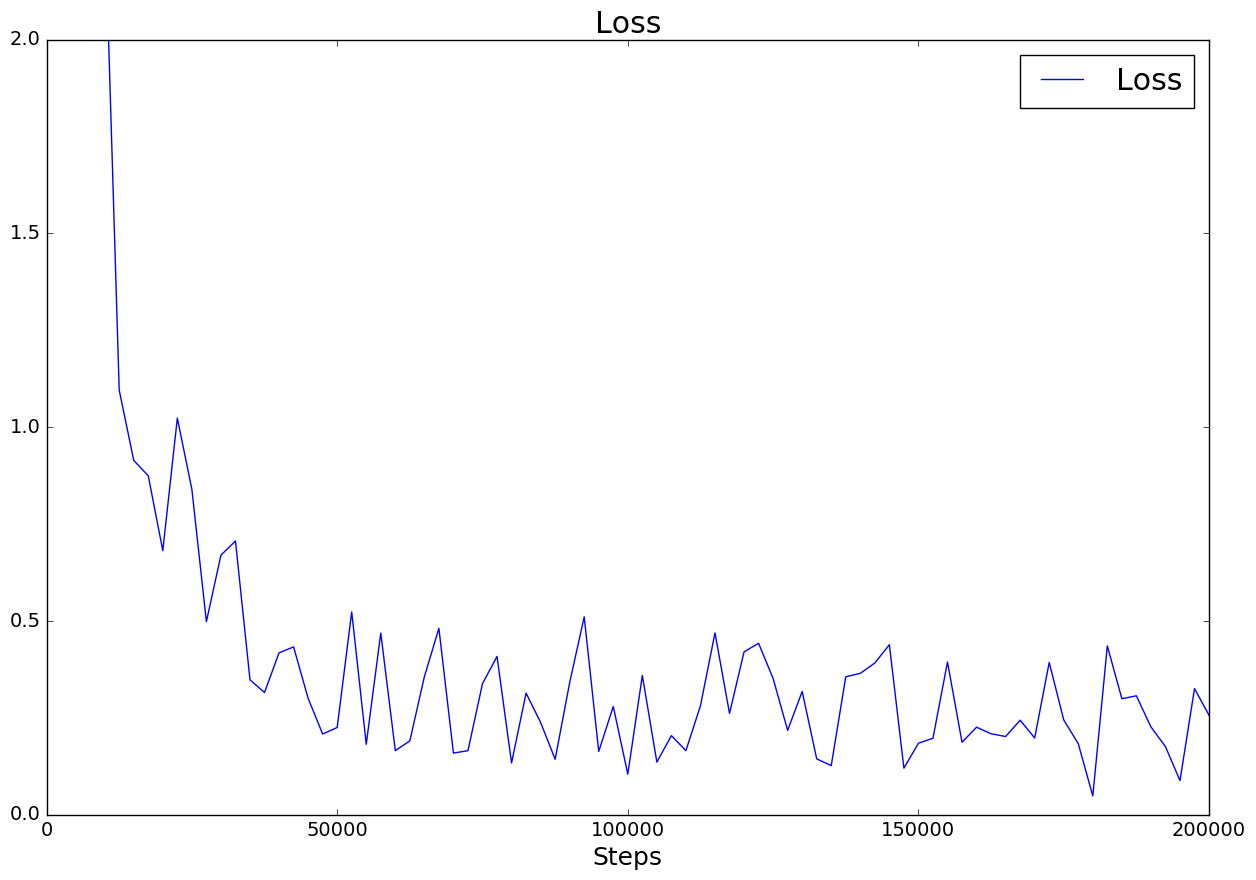

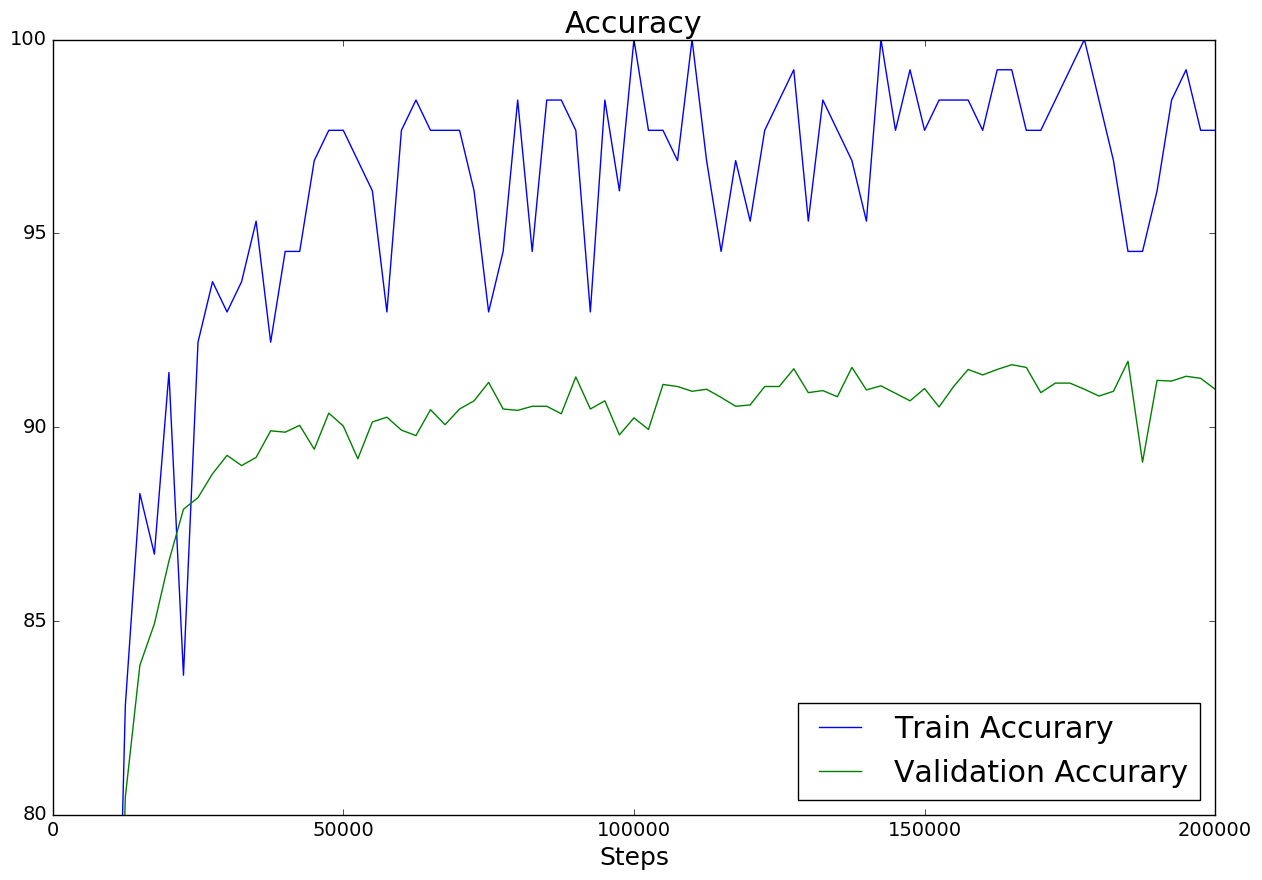

In [28]:
plot_results(acc_train,acc_valid,losses)